In [1]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = datasets.fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = None)
test_dataset = datasets.fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = None)

In [3]:
from nltk import WordNetLemmatizer
from nltk import pos_tag
import nltk
from nltk.corpus import wordnet
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
#Define Stopwords, here we use stopwords in text package
stop_words=text.ENGLISH_STOP_WORDS
print("number of stop_words in sklearn text:%s" % len(stop_words))

number of stop_words in sklearn text:318


In [4]:
#Lemmatization
lemmatizer=WordNetLemmatizer()
#Define lemmatizer pos_tag to deal with adj, verb, noun and adv separately
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

#Preprocessing: exclude some symbols and numbers in each sentence
exclude_sign="~#$%^&*(){}[]<>|+=1234567890"
replace_sign="@,.?!-;"
def preprocessing(data):
    processed_sentence=[]
    for i in range(len(data)):
        sentence=data[i]
        for c in exclude_sign:
            sentence=sentence.replace(c,"")
        for c in replace_sign:
            sentence=sentence.replace(c," ")
        processed_token=[lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]
        processed_sentence.append(" ".join(processed_token))
    return processed_sentence
#Training

vectorizer=CountVectorizer(stop_words='english',min_df=3)

In [5]:
#implement new dataset
categories_computer=['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
categories_rec=['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
computer_train=datasets.fetch_20newsgroups(subset = 'train', categories = categories_computer, shuffle = True, random_state = None).data
computer_test=datasets.fetch_20newsgroups(subset = 'test', categories = categories_computer, shuffle = True, random_state = None).data
recreation_train=datasets.fetch_20newsgroups(subset = 'train', categories = categories_rec, shuffle = True, random_state = None).data
recreation_test=datasets.fetch_20newsgroups(subset = 'test', categories = categories_rec, shuffle = True, random_state = None).data

In [6]:
#implement new dataset cont'd: combine train and test together and save as X_overall
X_train=computer_train+recreation_train
X_test=computer_test+recreation_test
X_overall=X_train+X_test
Y_train=[1]*len(computer_train)+[0]*len(recreation_train)
Y_test=[1]*len(computer_test)+[0]*len(recreation_test)
print(np.shape(X_overall))

(7882,)


In [7]:
#Lemmatization
processed_train_data=preprocessing(X_overall)



In [8]:
#Vectorization
data_vec=vectorizer.fit_transform(processed_train_data)



In [9]:
#TdIdf
from sklearn.feature_extraction.text import TfidfTransformer
TdT=TfidfTransformer()
data_vec_ti=TdT.fit_transform(data_vec)



In [10]:
#LSI
from sklearn.decomposition import TruncatedSVD
transformer=TruncatedSVD(n_components=50)
data_svd=transformer.fit_transform(data_vec_ti)
print(np.shape(data_svd))



(7882, 50)


In [11]:
#nmf
from sklearn.decomposition import NMF
nmf=NMF(n_components=50)
data_nmf=nmf.fit_transform(data_vec_ti)
print(np.shape(data_nmf))
print(type(data_svd))

(7882, 50)
<class 'numpy.ndarray'>


In [12]:
#error
xhat=np.dot(data_svd,transformer.components_)

data_mat=data_vec_ti.todense()
data_ar=data_mat.getA()

dif=xhat-data_mat
error=0
print(type(dif))
print(np.shape(dif))
error_lsi=np.sqrt(np.trace(np.dot(dif.T,dif)))
print('LSI error:')
print(error_lsi)

nmf_div=nmf.reconstruction_err_
print('NMF error:')
print(nmf_div)

<class 'numpy.matrix'>
(7882, 21423)
LSI error:
83.38389667525433
NMF error:
83.68714410508954


In [13]:
X_train_tf=data_svd[0:len(X_train)]
print(np.shape(X_train_tf))
X_test_tf=data_svd[len(X_train):]
print(np.shape(X_test_tf))

(4732, 50)
(3150, 50)


# Question 5
Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def LR_model (X_train, Y_train, X_test, Y_test, regularization_type,strength_inverse):
    LR_classifier=LogisticRegression(penalty=regularization_type,C=strength_inverse,solver='liblinear')
    LR_classifier.fit(X_train, Y_train)
    predict_target=LR_classifier.predict(X_test)
    predict_score=LR_classifier.decision_function(X_test)
    FPR, TPR, threshold=metrics.roc_curve(Y_test,predict_score)
    cvs=cross_val_score(LR_classifier,X_train, Y_train, cv=5)
    cvs=np.average(cvs)
    print('regularization_s is %f' %strength_inverse)
    print('5-fold cross validation score is %f' %(np.average(cvs)))
    return (predict_target, predict_score, FPR, TPR, threshold, cvs)



In [15]:
#Model Metrics
def evaluation(Y_predict, Y_test, FPR, TPR):
    confusion_matrix=metrics.confusion_matrix(Y_test,Y_predict)
    accuracy=metrics.accuracy_score(Y_test, Y_predict)
    recall=metrics.recall_score(Y_test, Y_predict, average='binary')
    precision=metrics.precision_score(Y_test, Y_predict, average='binary')
    f1_score=metrics.f1_score(Y_test, Y_predict, average='binary')
    roc=metrics.auc(FPR, TPR)
    plt.plot(FPR,TPR, lw=2, label='area under vurve= %0.4f' % roc)
    plt.show()
    print('Confusion matrix is: ')
    print(confusion_matrix)
    print('accuracy: %f' % accuracy)
    print('recall: %f' % recall)
    print('precision: %f' % precision)
    print('f1_score: %f' % f1_score)
    

c:\users\kingf\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\kingf\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

regularization_s is 1000.000000
5-fold cross validation score is 0.974853


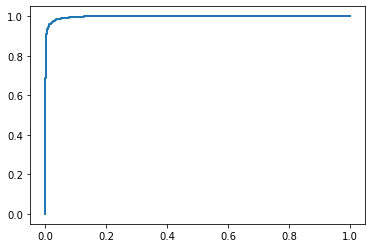

Confusion matrix is: 
[[1556   34]
 [  47 1513]]
accuracy: 0.974286
recall: 0.969872
precision: 0.978022
f1_score: 0.973930


In [25]:
#In order to set penalty as none. Apply L2 regularization, and set C as big as possible, then 1/lamba will be 
#as small as possible
predict_target, predict_score, FPR, TPR, threshold, cv_score = LR_model(X_train_tf, Y_train, X_test_tf, Y_test, 'l2',
                                                                        1000)
evaluation(predict_target, Y_test, FPR, TPR)


No. 1
regularization_s is 0.001000
5-fold cross validation score is 0.661245


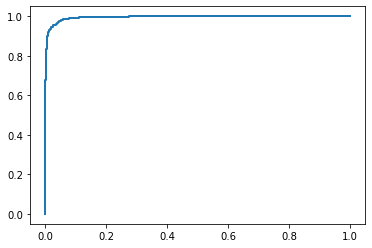

Confusion matrix is: 
[[1590    0]
 [ 970  590]]
accuracy: 0.692063
recall: 0.378205
precision: 1.000000
f1_score: 0.548837
No. 2
regularization_s is 0.010000
5-fold cross validation score is 0.943365


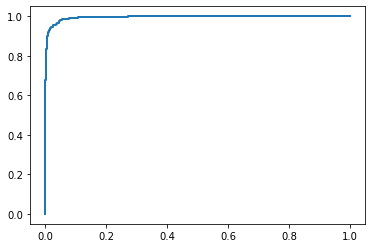

Confusion matrix is: 
[[1581    9]
 [ 168 1392]]
accuracy: 0.943810
recall: 0.892308
precision: 0.993576
f1_score: 0.940223
No. 3
regularization_s is 0.100000
5-fold cross validation score is 0.969782


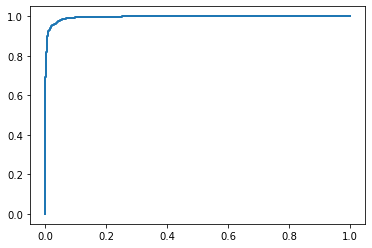

Confusion matrix is: 
[[1560   30]
 [  78 1482]]
accuracy: 0.965714
recall: 0.950000
precision: 0.980159
f1_score: 0.964844
No. 4
regularization_s is 1.000000
5-fold cross validation score is 0.972951


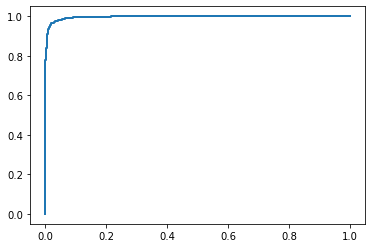

Confusion matrix is: 
[[1556   34]
 [  55 1505]]
accuracy: 0.971746
recall: 0.964744
precision: 0.977908
f1_score: 0.971281
No. 5
regularization_s is 10.000000
5-fold cross validation score is 0.976121


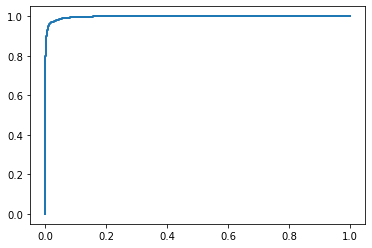

Confusion matrix is: 
[[1559   31]
 [  49 1511]]
accuracy: 0.974603
recall: 0.968590
precision: 0.979896
f1_score: 0.974210
No. 6
regularization_s is 100.000000
5-fold cross validation score is 0.976544


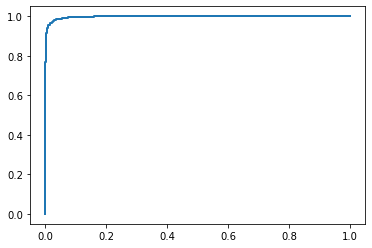

Confusion matrix is: 
[[1556   34]
 [  48 1512]]
accuracy: 0.973968
recall: 0.969231
precision: 0.978008
f1_score: 0.973599
No. 7
regularization_s is 1000.000000
5-fold cross validation score is 0.974853


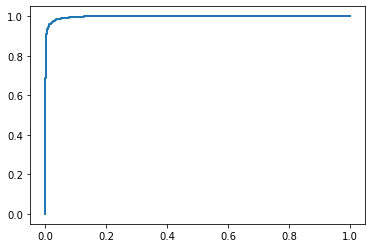

Confusion matrix is: 
[[1556   34]
 [  47 1513]]
accuracy: 0.974286
recall: 0.969872
precision: 0.978022
f1_score: 0.973930
The model with the best validation score is the model with regularization strengh as 100.000000 and cross validation score is 0.976544


In [30]:
#use 5-fold cross validation find the best regularization strength for L2
cv_max=0
regu_best=0

for i in range(-3,4):
    print('No. %i' %(i+4))
    predict_target,predict_score,FPR, TPR, threshold, cv_score=LR_model(X_train_tf, Y_train, X_test_tf, Y_test, 'l2', 10**i )
    evaluation(predict_target, Y_test, FPR, TPR)
    if cv_score>cv_max:
        cv_max=cv_score
        regu_best=10**i
print('The model with the best validation score is the model with regularization strengh as %f and cross validation score is %f' 
      %(regu_best,cv_max))





No. 1
regularization_s is 0.001000
5-fold cross validation score is 0.504861


c:\users\kingf\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


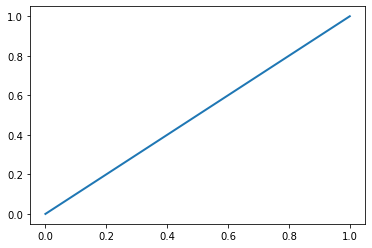

Confusion matrix is: 
[[1590    0]
 [1560    0]]
accuracy: 0.504762
recall: 0.000000
precision: 0.000000
f1_score: 0.000000
No. 2
regularization_s is 0.010000
5-fold cross validation score is 0.918006


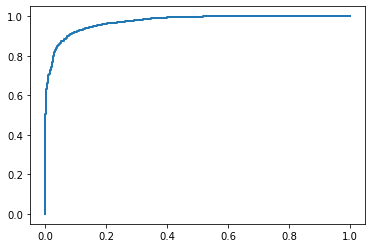

Confusion matrix is: 
[[1418  172]
 [ 116 1444]]
accuracy: 0.908571
recall: 0.925641
precision: 0.893564
f1_score: 0.909320
No. 3
regularization_s is 0.100000
5-fold cross validation score is 0.960693


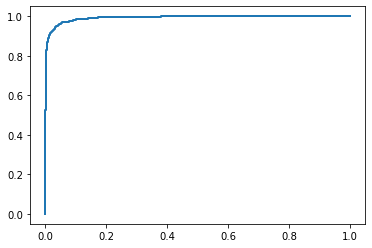

Confusion matrix is: 
[[1541   49]
 [  91 1469]]
accuracy: 0.955556
recall: 0.941667
precision: 0.967721
f1_score: 0.954516
No. 4
regularization_s is 1.000000
5-fold cross validation score is 0.970627


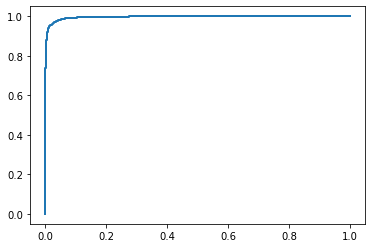

Confusion matrix is: 
[[1554   36]
 [  63 1497]]
accuracy: 0.968571
recall: 0.959615
precision: 0.976517
f1_score: 0.967992
No. 5
regularization_s is 10.000000
5-fold cross validation score is 0.975064


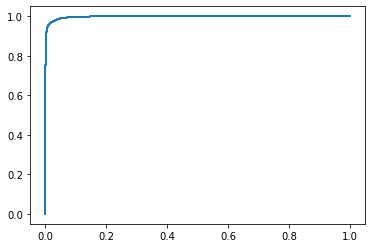

Confusion matrix is: 
[[1558   32]
 [  47 1513]]
accuracy: 0.974921
recall: 0.969872
precision: 0.979288
f1_score: 0.974557
No. 6
regularization_s is 100.000000
5-fold cross validation score is 0.975698


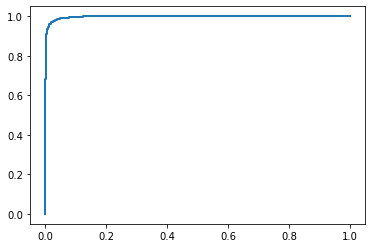

Confusion matrix is: 
[[1555   35]
 [  47 1513]]
accuracy: 0.973968
recall: 0.969872
precision: 0.977390
f1_score: 0.973616
No. 7
regularization_s is 1000.000000
5-fold cross validation score is 0.975275


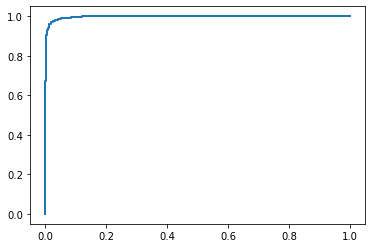

Confusion matrix is: 
[[1554   36]
 [  47 1513]]
accuracy: 0.973651
recall: 0.969872
precision: 0.976759
f1_score: 0.973303
The model with the best validation score is the model with regularization strengh as 100.000000 and cross validation score is 0.975698


In [31]:
#use 5-fold cross validation find the best regularization strength L1
cv_max=0
regu_best=0

for i in range(-3,4):
    print('No. %i' %(i+4))
    predict_target,predict_score,FPR, TPR, threshold, cv_score=LR_model(X_train_tf, Y_train, X_test_tf, Y_test, 'l1', 10**i )
    evaluation(predict_target, Y_test, FPR, TPR)
    if cv_score>cv_max:
        cv_max=cv_score
        regu_best=10**i
print('The model with the best validation score is the model with regularization strengh as %f and cross validation score is %f' 
      %(regu_best,cv_max))






In [35]:
#LR_classifier_test=LogisticRegression(penalty='l2',C=100,solver='liblinear')
#LR_classifier_test.fit(X_train_tf, Y_train)
#print(LR_classifier_test.score(X_train_tf, Y_train))

#from sklearn import svm

#SVM_classifier=svm.SVC(C=1000,gamma='auto')
#SVM_classifier.fit(X_train_tf,Y_train)
#print(SVM_classifier.score(X_train_tf,Y_train))


0.9799239222316145
0.9792899408284024
